Group 4 Final Project: Predicting Flight Delays

Anusha Bhat, Sumasree Ragi, Kirthi Rao, Manas Vemuri


December 10, 2024

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression

import itertools
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, roc_curve
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, accuracy_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# Data Cleaning


In [ ]:
# load in original data
df = pd.read_csv("Jan_2019_ontime.csv")

df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


In [ ]:
# check the columns
df.columns

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEP_TIME',
       'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DEL15', 'CANCELLED',
       'DIVERTED', 'DISTANCE', 'Unnamed: 21'],
      dtype='object')

In [ ]:
# count columns and rows
df.shape

(583985, 22)

In [ ]:
# drop unnecessary columns and make a copy of df for cleaned df
df_clean = df[['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN',
    'DEST', 'DEP_DEL15', 'DEP_TIME_BLK', 'DISTANCE']].copy()

In [ ]:
# get the unique time blocks
df_clean['DEP_TIME_BLK'].unique()

array(['0600-0659', '1400-1459', '1200-1259', '1500-1559', '1900-1959',
       '0900-0959', '1000-1059', '2000-2059', '1300-1359', '1100-1159',
       '0800-0859', '2200-2259', '1600-1659', '1700-1759', '2100-2159',
       '0700-0759', '1800-1859', '0001-0559', '2300-2359'], dtype=object)

In [ ]:
# function to reclassify departure time blocks into categories of time of day
def get_dept_time_block(time_block):
    hour = int(time_block[:2])
    if 0 <= hour < 4:
        return "Pre Dawn"
    elif 4 <= hour < 9:
        return "Early Morning"
    elif 9 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 13:
        return "Noon"
    elif 13 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 20:
        return "Evening"
    else: return "Night"


In [ ]:
# transform column from time blocks to times of day categories
df_clean['DEP_TIME_BLK'] = df_clean['DEP_TIME_BLK'].apply(get_dept_time_block)

In [ ]:
# check column updated
df_clean['DEP_TIME_BLK'].head(10)

,DEP_TIME_BLK
0,Early Morning
1,Afternoon
2,Noon
3,Afternoon
4,Evening
5,Morning
6,Afternoon
7,Afternoon
8,Morning
9,Noon


We have reclassified the departure time block column from hourly intervals to time of day groups. We define the time blocks as:

*   Pre Dawn: 12:00 AM - 3:59 AM
*   Early Morning: 4:00 AM - 8:59 AM
*   Morning: 9:00 AM - 11:59 AM
*   Noon: 12:00 PM - 12:59 PM
*   Afternoon: 1:00 PM - 4:59 PM
*   Evening: 5:00 PM - 7:59 PM
*   Night: 8:00 PM - 11:59 AM

In [ ]:
# get the unique airlines
df_clean['OP_UNIQUE_CARRIER'].unique()

array(['9E', 'AA', 'MQ', 'G4', 'OH', 'B6', 'YV', 'EV', 'F9', 'YX', 'HA',
       'NK', 'OO', 'WN', 'AS', 'UA', 'DL'], dtype=object)

In [ ]:
# function to reclassify carrier code to budget v.s. non-budget airlines
def get_airline_type(carrier):
    if carrier in ['G4', 'B6', 'F9', 'NK', 'WN']:
        return 'Budget'
    else: return "Non-budget"

In [ ]:
# transform column from carrier codes to budget category
df_clean['OP_UNIQUE_CARRIER'] = df_clean['OP_UNIQUE_CARRIER'].apply(get_airline_type)

In [ ]:
# check column updated
df_clean['OP_UNIQUE_CARRIER'].head(10)

,OP_UNIQUE_CARRIER
0,Non-budget
1,Non-budget
2,Non-budget
3,Non-budget
4,Non-budget
5,Non-budget
6,Non-budget
7,Non-budget
8,Non-budget
9,Non-budget


We have reclassified the carrier ID column from airline company ID codes to the groups budget v.s. non-budget airlines. The following list is how we reclassified the airlines:

Airline Carriers:

*  9E - Endeavor Air → Non-budget
*  AA - American Airlines → Non-budget
*  MQ - Envoy Air → Non-budget
*  G4 - Allegiant Air → budget
*  OH - Pacific Southwest Airlines → Non-budget
*  B6 - JetBlue Airways → budget
*  YV - Mesa Airlines → Non-budget
*  EV - ExpressJet Airlines → Non-budget
*  F9 - Frontier Airlines → budget
*  YX - Republic Airlines → Non-budget
*  HA - Hawaiian Airlines → Non-budget
*  NK - Spirit Airlines → budget
*  OO - SkyWest Airlines → Non-budget
*  WN - Southwest Airlines → budget
*  AS - Alaska Airlines → Non-budget
* UA - United Airlines → Non-budget
* DL - Delta Airlines → Non-budget







In [ ]:
# create a df that has the number of flights from each origin airport
origin_airport_df = df_clean.groupby('ORIGIN').size().reset_index(name='count').sort_values(by='count', ascending=False)
origin_airport_df['count'] = origin_airport_df['count'].astype(int)

In [ ]:
# check df is correct
origin_airport_df.head()

,ORIGIN,count
19,ATL,31155
238,ORD,26216
89,DFW,23063
68,CLT,19100
88,DEN,18507


In [ ]:
# get percentiles for classifying origin airports based on flight traffic
origin_airport_df.describe()

,count
count,346.000000
mean,1687.817919
std,3942.287432
min,8.000000
25%,81.000000
50%,259.000000
75%,1057.750000
max,31155.000000


In [ ]:
# reclassify origin airports into volume type based on flight count
def get_airport_type(flight_count):
    if flight_count >= 1000 :
        return "High Volume"
    elif 300 < flight_count < 1000:
        return "Medium Volume"
    else: return "Low Volume"

In [ ]:
# transform column from origin airport to flight traffic volume type
origin_airport_df['ORIGIN_AIRPORT_TYPE'] = origin_airport_df['count'].apply(get_airport_type)

# Merge the origin airport types back into the original dataframe
df_clean = df_clean.merge(origin_airport_df[['ORIGIN', 'ORIGIN_AIRPORT_TYPE']], on='ORIGIN', how='left')

In [ ]:
# create a df that has the number of flights from each dest airport
dest_airport_df = df_clean.groupby('DEST').size().reset_index(name='count').sort_values(by='count', ascending=False)
dest_airport_df['count'] = dest_airport_df['count'].astype(int)

# get percentiles for classifying dest airports based on flight traffic
dest_airport_df.describe()

# similar percentiles as origin airport, so use same thresholds for classifying

,count
count,346.000000
mean,1687.817919
std,3942.406894
min,8.000000
25%,81.000000
50%,258.500000
75%,1059.500000
max,31151.000000


In [ ]:
# transform column from dest airport to flight traffic volume type
dest_airport_df['DEST_AIRPORT_TYPE'] = dest_airport_df['count'].apply(get_airport_type)

# Merge the dest airport types back into the original dataframe
df_clean = df_clean.merge(dest_airport_df[['DEST', 'DEST_AIRPORT_TYPE']], on='DEST', how='left')

We have reclassfieid the origin and destination airport columns from containing the airport codes to having the groups High Volume, Medium Volume, and Low Volume based on flight traffic using percentiles of flight counts per airport. We classified the groupings as:

*   High Volume: Airports with >= 1000 flights
*   Medium Volume: Airports with 3000-999 flights
*   Low Volume: Airports with < 300 flights

The group thresholds were determined based on the percentiles from the summary statistics of flight counts. Since both destination and origin airports had similar values for the 25th and 75th percentiles, the thresholds were the same for both columns.

In [ ]:
# check cleaned df
df_clean.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,DISTANCE,ORIGIN_AIRPORT_TYPE,DEST_AIRPORT_TYPE
0,1,2,Non-budget,GNV,ATL,0.0,Early Morning,300.0,Medium Volume,High Volume
1,1,2,Non-budget,MSP,CVG,0.0,Afternoon,596.0,High Volume,High Volume
2,1,2,Non-budget,DTW,CVG,0.0,Noon,229.0,High Volume,High Volume
3,1,2,Non-budget,TLH,ATL,0.0,Afternoon,223.0,Medium Volume,High Volume
4,1,2,Non-budget,ATL,FSM,0.0,Evening,579.0,High Volume,Low Volume


In [ ]:
# save cleaned df to csv for future use
df.to_csv('flights_df_cleaned.csv', index=False)

# Exploratory Data Analysis

We will conduct EDA on the entire dataset as well as specifically looking at rows with delayed flights to inform our model development process.

In [ ]:
# check the data types
df_clean.dtypes

,0
DAY_OF_MONTH,int64
DAY_OF_WEEK,int64
OP_UNIQUE_CARRIER,object
ORIGIN,object
DEST,object
DEP_DEL15,float64
DEP_TIME_BLK,object
DISTANCE,float64
ORIGIN_AIRPORT_TYPE,object
DEST_AIRPORT_TYPE,object


In [ ]:
# check the shape of the df
df_clean.shape

(583985, 10)

In [ ]:
# check null count
df_clean.isnull().sum()

# note: the null values in departure delay are because those flights were
# either cancelled or diverted

,0
DAY_OF_MONTH,0
DAY_OF_WEEK,0
OP_UNIQUE_CARRIER,0
ORIGIN,0
DEST,0
DEP_DEL15,16355
DEP_TIME_BLK,0
DISTANCE,0
ORIGIN_AIRPORT_TYPE,0
DEST_AIRPORT_TYPE,0


In [ ]:
# summary stats on numeric cols
df_clean.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,DEP_DEL15,DISTANCE
count,583985.000000,583985.000000,567630.000000,583985.000000
mean,15.960088,3.835626,0.174281,797.742767
std,8.987942,1.921899,0.379351,589.999261
min,1.000000,1.000000,0.000000,31.000000
25%,8.000000,2.000000,0.000000,363.000000
50%,16.000000,4.000000,0.000000,640.000000
75%,24.000000,5.000000,0.000000,1037.000000
max,31.000000,7.000000,1.000000,4983.000000


In [ ]:
# how many unique origin airports in df
df_clean['ORIGIN'].nunique()

346

In [ ]:
# how many unique destination airports in df
df_clean['ORIGIN'].nunique()

In [ ]:
# check how many flights were delayed, diverted, or cancelled
del_flights = df[["DEP_DEL15", "DIVERTED", "CANCELLED"]].sum()

del_flights

,0
DEP_DEL15,98927.0
DIVERTED,1296.0
CANCELLED,16726.0


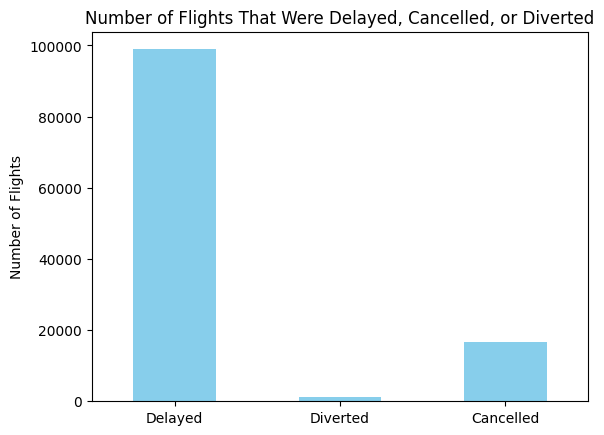

In [ ]:
# visualize the number of flights that were delayed, cancelled, or diverted
del_flights.plot(kind='bar', color='skyblue')

plt.title("Number of Flights That Were Delayed, Cancelled, or Diverted")
plt.ylabel('Number of Flights')
plt.xticks(ticks=(0, 1, 2), labels=['Delayed', 'Diverted', 'Cancelled'], rotation=0)

plt.show()

Since there are not enough flights in our dataset that were diverted or cancelled, we chose to retain only Delayed flights as our final target variable. We can not build a meaningful multinomial regression model using diverted and  cancelled flights due to the disproportionate amount of delayed flights.

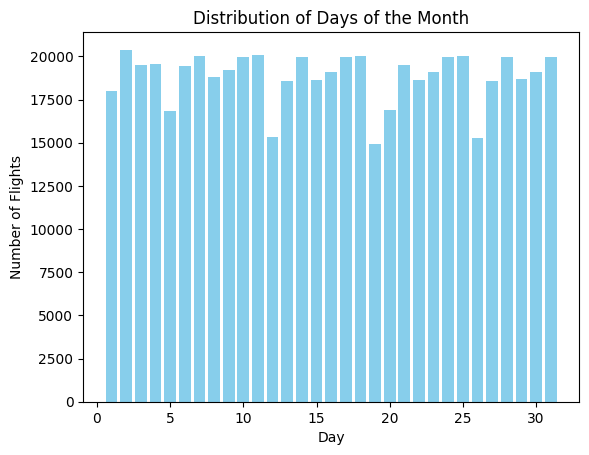

In [ ]:
# visualizing number of flights per day of the month
day_counts = df_clean['DAY_OF_MONTH'].value_counts().sort_index()

plt.bar(day_counts.index, day_counts.values, color = "skyblue")

plt.title("Distribution of Days of the Month")
plt.xlabel("Day")
plt.ylabel("Number of Flights")

plt.show()

There is a cyclic pattern to the number of flights, with the number of flights repeatedly increasing then decreasing throughout the month. This is likely a reflection of the number of flights for each day of the week.

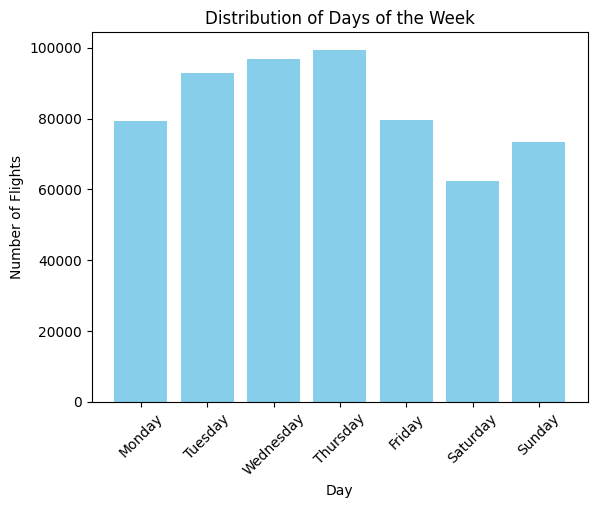

In [ ]:
# visualize the number of flights per day of week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

day_counts = df_clean['DAY_OF_WEEK'].value_counts().sort_index()

plt.bar(day_counts.index - 1, day_counts.values, color = "skyblue")

plt.title("Distribution of Days of the Week")
plt.xticks(ticks=range(7), labels=day_names, rotation=45)
plt.xlabel("Day")
plt.ylabel("Number of Flights")

plt.show()

Saturdays and Sundays have the least number of flights, whereas Wednesday and Thursday have the most number of flights.

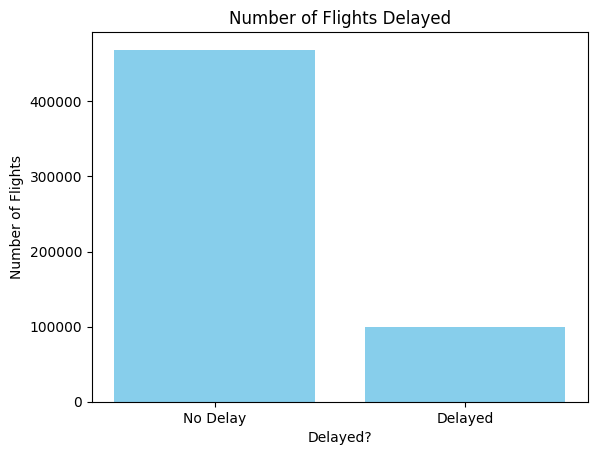

In [ ]:
delay_names = ['No Delay', 'Delayed']

delay_counts = df_clean['DEP_DEL15'].value_counts().sort_index()

plt.bar(delay_counts.index, delay_counts.values, color = "skyblue")

plt.title("Number of Flights Delayed")
plt.xticks(ticks=range(2), labels=delay_names, rotation=0)
plt.xlabel("Delayed?")
plt.ylabel("Number of Flights")

plt.show()

There are substantially more not delayed flights than delayed flights in our dataset. Due to this disproportion, we may have to undersample when constructing our model.

In [ ]:
print(df_clean[df_clean["DEP_DEL15"] == 0].shape)
print(df_clean[df_clean["DEP_DEL15"] == 1].shape)
print((98927)/(468703 + 98927))
print((468703)/(468703 + 98927))

(468703, 10)
(98927, 10)
0.17428078149498794
0.8257192185050121


Only 17.43% of flights in our dataset are delayed.

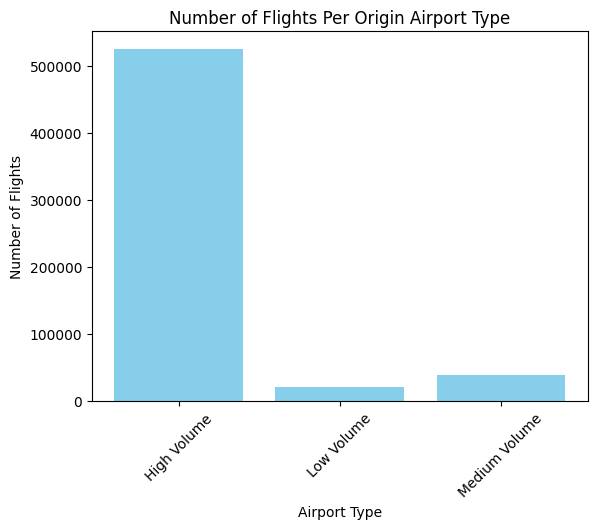

In [ ]:
# visualize number of flights per origin airport type
origin_counts = df_clean['ORIGIN_AIRPORT_TYPE'].value_counts().sort_index()

plt.bar(origin_counts.index, origin_counts.values, color = "skyblue")

plt.title("Number of Flights Per Origin Airport Type")
plt.xticks(rotation = 45)
plt.xlabel("Airport Type")
plt.ylabel("Number of Flights")

plt.show()

Text(0, 0.5, 'Number of Flights')

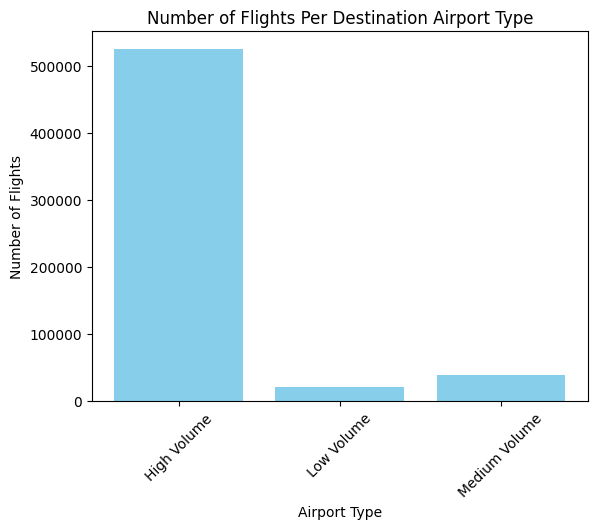

In [ ]:
# visualize number of flights per destination airport type
dest_counts = df_clean['DEST_AIRPORT_TYPE'].value_counts().sort_index()

plt.bar(dest_counts.index, dest_counts.values, color = "skyblue")

plt.title("Number of Flights Per Destination Airport Type")
plt.xticks(rotation = 45)
plt.xlabel("Airport Type")
plt.ylabel("Number of Flights")

As expected, high volume destination and origin airports have the highest number of flights.

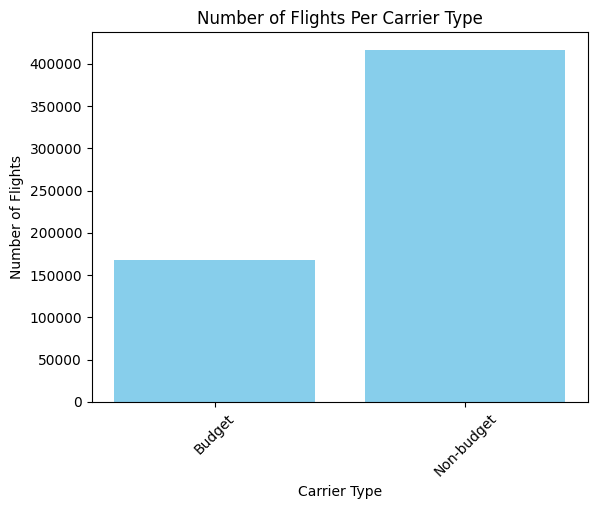

In [ ]:
# visualize number of flights per carrier type
carrier_counts = df_clean['OP_UNIQUE_CARRIER'].value_counts().sort_index()

plt.bar(carrier_counts.index, carrier_counts.values, color = "skyblue")

plt.title("Number of Flights Per Carrier Type")
plt.xticks(rotation = 45)
plt.xlabel("Carrier Type")
plt.ylabel("Number of Flights")

plt.show()

There are substantially more non-budget flights than budget flights in our dataset.

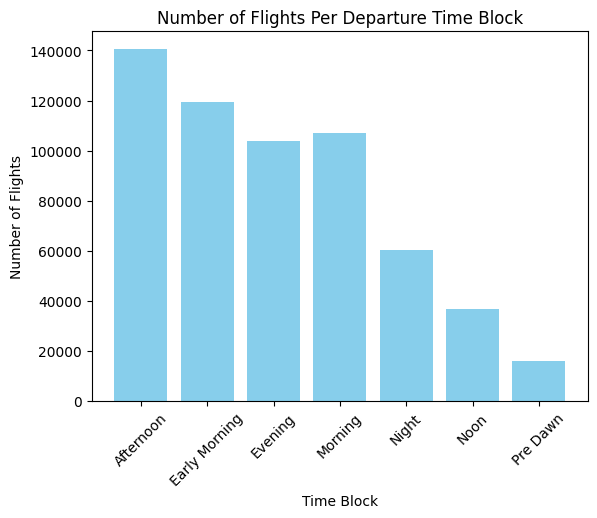

In [ ]:
time_counts = df_clean['DEP_TIME_BLK'].value_counts().sort_index()

plt.bar(time_counts.index, time_counts.values, color = "skyblue")

plt.title("Number of Flights Per Departure Time Block")
plt.xticks(rotation = 45)
plt.xlabel("Time Block")
plt.ylabel("Number of Flights")

plt.show()

The afternoon and early morning time blocks have the most flights, whereas, pre-dawn has the least amount of flights.

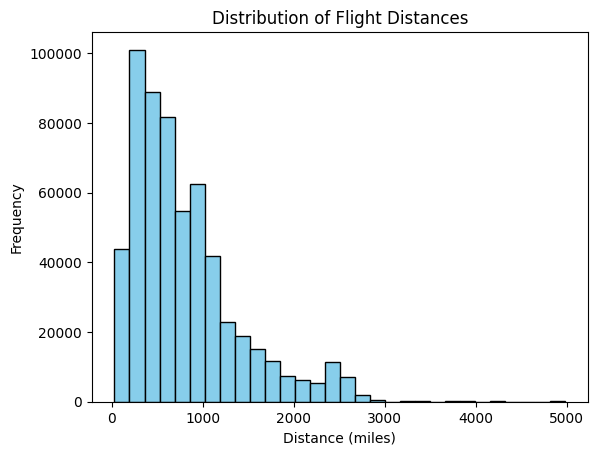

In [ ]:
plt.hist(df['DISTANCE'], bins=30, edgecolor='black', color = "skyblue")


plt.title("Distribution of Flight Distances")
plt.xlabel("Distance (miles)")
plt.ylabel("Frequency")

plt.show()

Most flights have shorter travel distances.

In [ ]:
# filter only for delayed flights
temp_df = df_clean[df_clean["DEP_DEL15"] == 1]

In [ ]:
# calculate the proportion of delayed flights by each airport type for both
# origin and destination airports
origin_delayed_counts = temp_df.groupby('ORIGIN_AIRPORT_TYPE').size()
origin_proportions = origin_delayed_counts / len(temp_df) * 100

dest_delayed_counts = temp_df.groupby('DEST_AIRPORT_TYPE').size()
dest_proportions = dest_delayed_counts / len(temp_df) * 100

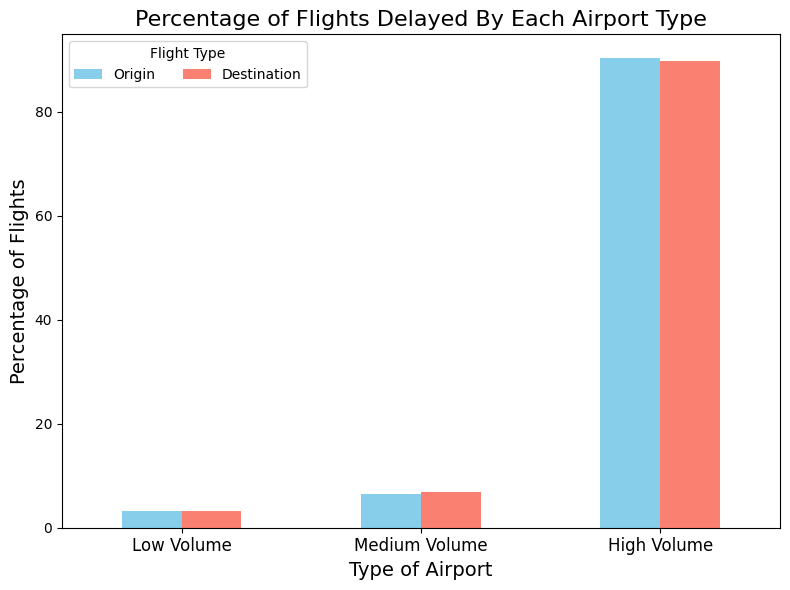

In [ ]:
# visualize the percentages

# Create a df with the percentage values for plotting on one graph
flight_props = pd.DataFrame({
    'Origin': origin_proportions,
    'Destination': dest_proportions
}).fillna(0)


ordered_categories = ['Low Volume', 'Medium Volume', 'High Volume']
flight_counts = flight_props.reindex(ordered_categories)

flight_counts.plot(kind='bar', figsize=(8, 6), stacked=False, color=['skyblue', 'salmon'])

# Customize the plot
plt.title('Percentage of Flights Delayed By Each Airport Type', fontsize=16)
plt.xlabel('Type of Airport', fontsize=14)
plt.ylabel('Percentage of Flights', fontsize=14)
plt.xticks(rotation=0, fontsize = 12)
plt.legend(title='Flight Type', ncol=2)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
flight_props

,Origin,Destination
High Volume,90.367645,89.751029
Low Volume,3.200340,3.296370
Medium Volume,6.432016,6.952601


For both origin and destination airports, the majority of delayed flights were from high volume airports.

In [ ]:
# find proportion of each time block for delayed flights
delayed_counts = temp_df.groupby('DEP_TIME_BLK').size()
proportions = delayed_counts / len(temp_df)

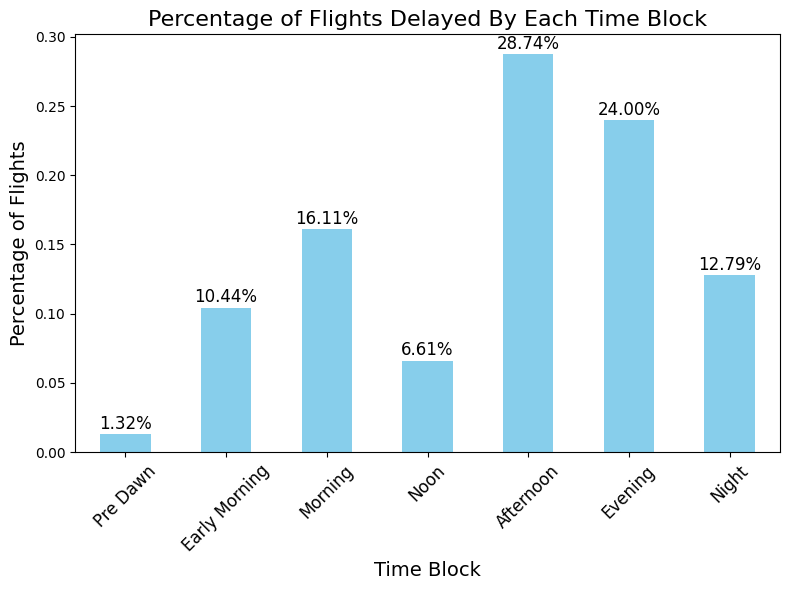

In [ ]:
# visualize the percentages
ordered_categories = ["Pre Dawn", "Early Morning", "Morning",
                      "Noon", "Afternoon", "Evening", "Night"]
proportions = proportions.reindex(ordered_categories)

ax = proportions.plot(kind='bar', figsize=(8, 6), stacked=False, color=['skyblue'])

for i, v in enumerate(proportions):
    ax.text(i, v + 0.001, f'{v:.2%}', ha='center', va='bottom', fontsize=12)

plt.title('Percentage of Flights Delayed By Each Time Block', fontsize=16)
plt.xlabel('Time Block', fontsize=14)
plt.ylabel('Percentage of Flights', fontsize=14)
plt.xticks(rotation = 45, fontsize = 12)


plt.tight_layout()
plt.show()

A majority of delayed flights were flewn in the afternoon, evening, and night time blocks.

In [ ]:
# find proportion of delayed flights for each carrier type
carr_delayed_counts = temp_df.groupby('OP_UNIQUE_CARRIER').size()
proportions = carr_delayed_counts / len(temp_df)

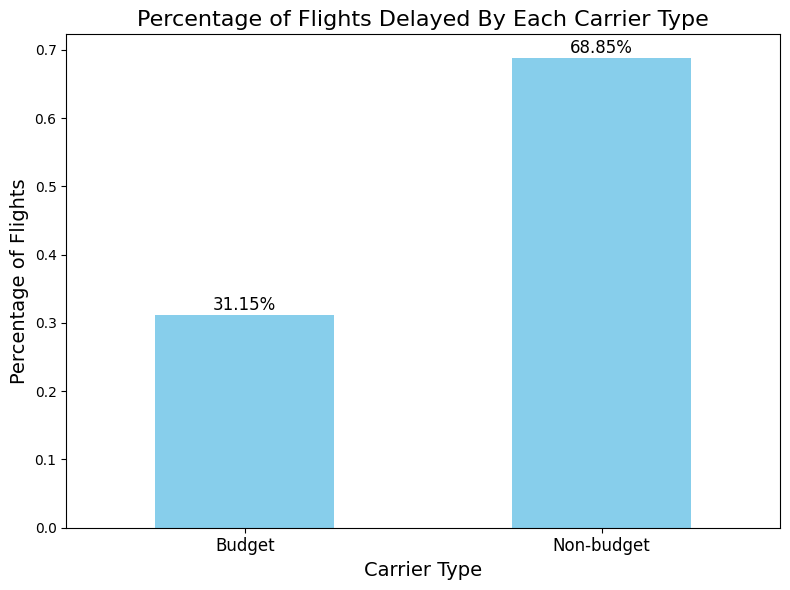

In [ ]:
# visualize the percentages
ax = proportions.plot(kind='bar', figsize=(8, 6), stacked=False, color=['skyblue'])

for i, v in enumerate(proportions):
    ax.text(i, v + 0.001, f'{v:.2%}', ha='center', va='bottom', fontsize=12)


plt.title('Percentage of Flights Delayed By Each Carrier Type', fontsize=16)
plt.xlabel('Carrier Type', fontsize=14)
plt.ylabel('Percentage of Flights', fontsize=14)
plt.xticks(rotation = 0, fontsize = 12)


plt.tight_layout()
plt.show()

Most delayed flights were from non-budget carriers.

In [ ]:
# find proportion of delayed flights for each day of the week
day_week_delayed_counts = temp_df.groupby('DAY_OF_WEEK').size()
proportions = day_week_delayed_counts / len(temp_df)

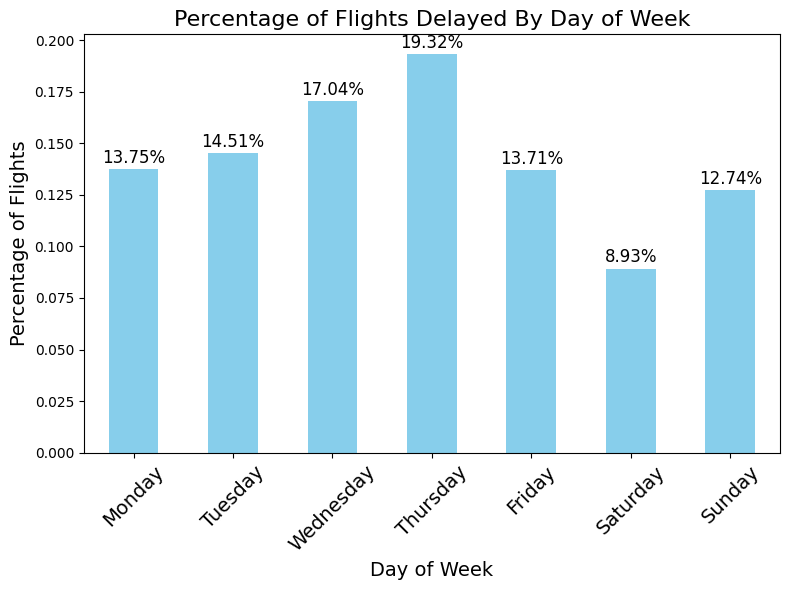

In [ ]:
# visualize percentages
ax = proportions.plot(kind='bar', figsize=(8, 6), stacked=False, color=['skyblue'])

for i, v in enumerate(proportions):
    ax.text(i, v + 0.001, f'{v:.2%}', ha='center', va='bottom', fontsize=12)


day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.title('Percentage of Flights Delayed By Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.xticks(ticks=range(7), labels=day_names, rotation=45, fontsize = 14)
plt.ylabel('Percentage of Flights', fontsize=14)


plt.tight_layout()
plt.show()

Thursday and Wednesday had the biggest share of delayed flights.

In [ ]:
# find proportion of delayed flights for each day of the month
day_month_delayed_counts = temp_df.groupby('DAY_OF_MONTH').size()
proportions = day_month_delayed_counts / len(temp_df) * 100

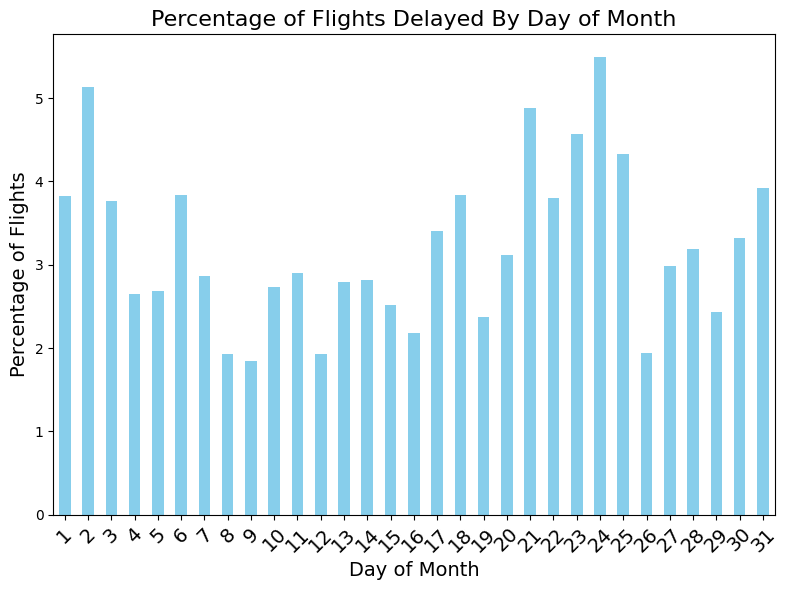

In [ ]:
# visualize the percentages
proportions.plot(kind='bar', figsize=(8, 6), stacked=False, color=['skyblue'])
plt.title('Percentage of Flights Delayed By Day of Month', fontsize=16)
plt.xlabel('Day of Month', fontsize=14)
plt.xticks(rotation= 45, fontsize = 14)
plt.ylabel('Percentage of Flights', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

Similar to the flight counts for day of the month, the days of the month with higher proportions of delayed flights reflect the proportions of delayed flights for days of the week.

In [ ]:
# creating a heatcounting the number of delayed flights for each airport
delayed_flights_origin = temp_df.groupby('ORIGIN').size()
delayed_flights_destination = temp_df.groupby('DEST').size()

# only want to plot the top 20 counts for easy visualization
top_20_delayed_origin = delayed_flights_origin.sort_values(ascending=False).head(20)
top_20_delayed_destination = delayed_flights_destination.sort_values(ascending=False).head(20)


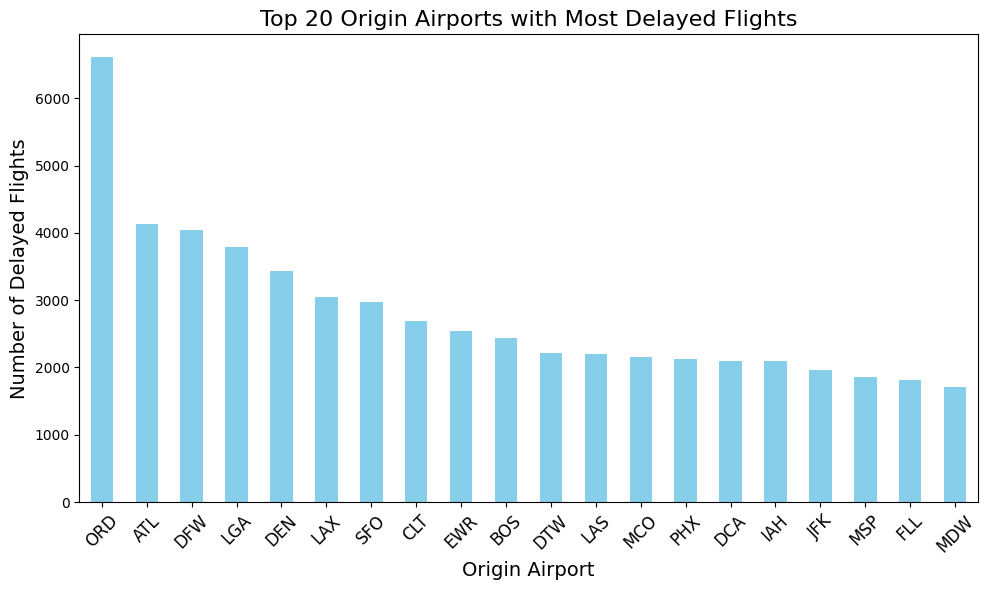

In [ ]:
# visualizing delayed flights per origin airport
top_20_delayed_origin.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 20 Origin Airports with Most Delayed Flights', fontsize=16)
plt.xlabel('Origin Airport', fontsize=14)
plt.ylabel('Number of Delayed Flights', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

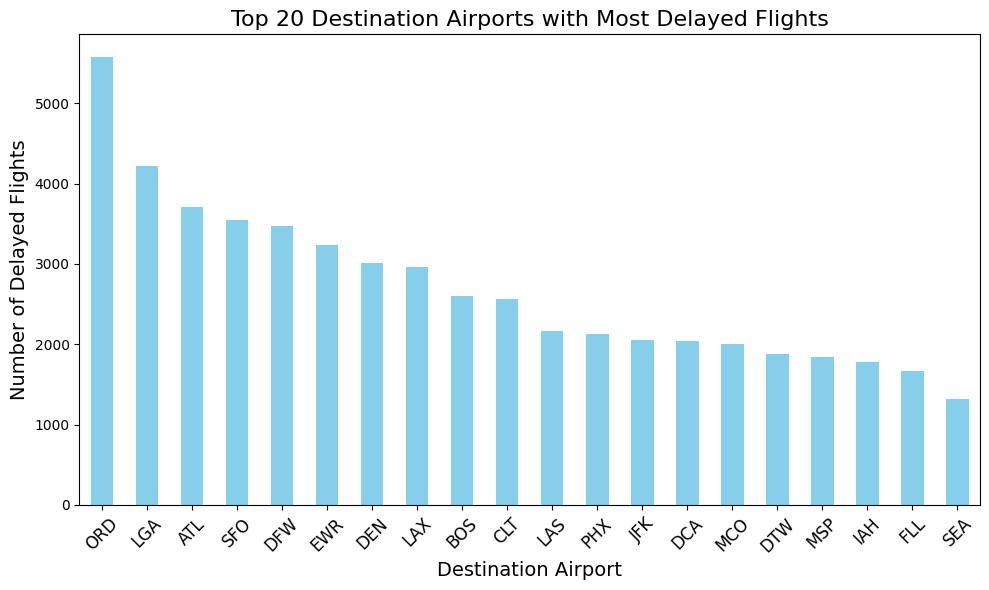

In [ ]:
# visualizing delayed flights per origin airport
top_20_delayed_destination.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 20 Destination Airports with Most Delayed Flights', fontsize=16)
plt.xlabel('Destination Airport', fontsize=14)
plt.ylabel('Number of Delayed Flights', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

ORD, ATL, DFW, LGA, and DEN have the most delayed flights out of all origin airports. Similarly, we see ORD, LGA, ATL, and DFW again in the top 5 for most delayed flights in the destination airports--acompanied by SFO as well.

In [ ]:
# creating a heatmap of delayed flight counts for origin-destination airport combinations
delayed_counts = temp_df.groupby(['ORIGIN', 'DEST']).size()
top_20_delayed = delayed_counts.sort_values(ascending=False).head(20)
pivot_table = top_20_delayed.unstack(fill_value=0)

# creating a heatmap of total flight counts for origin-destination airport combinations
total_counts = df_clean.groupby(['ORIGIN', 'DEST']).size()
top_20_total = total_counts.sort_values(ascending=False).head(20)
pivot_table_total = top_20_total.unstack(fill_value=0)

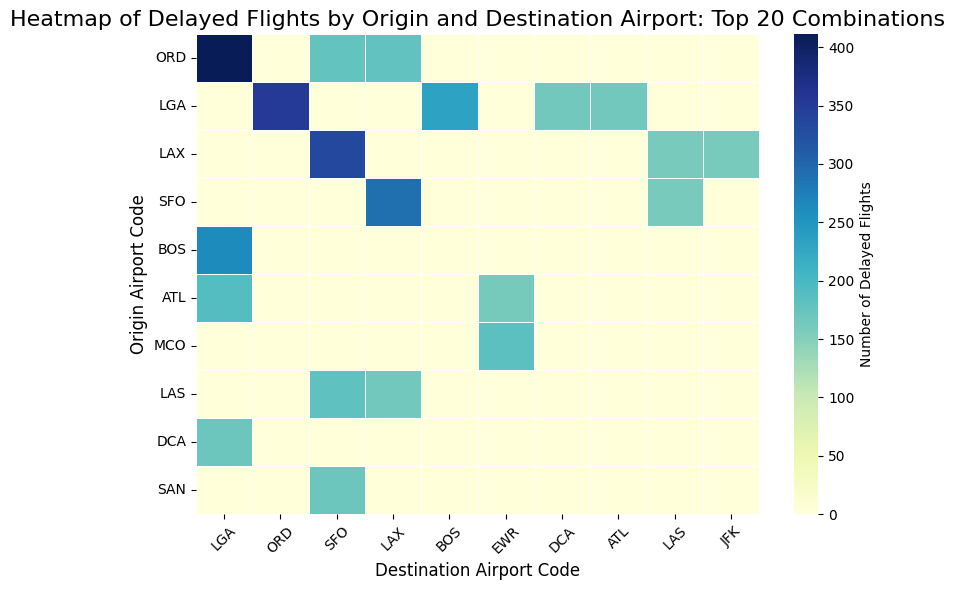

In [ ]:
# Plotting the delayed flights heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=False, fmt='d', linewidths=0.5, cbar_kws={'label': 'Number of Delayed Flights'})


plt.title('Heatmap of Delayed Flights by Origin and Destination Airport: Top 20 Combinations',
          fontsize=16)
plt.xlabel('Destination Airport Code', fontsize=12)
plt.ylabel('Origin Airport Code', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()


plt.show()

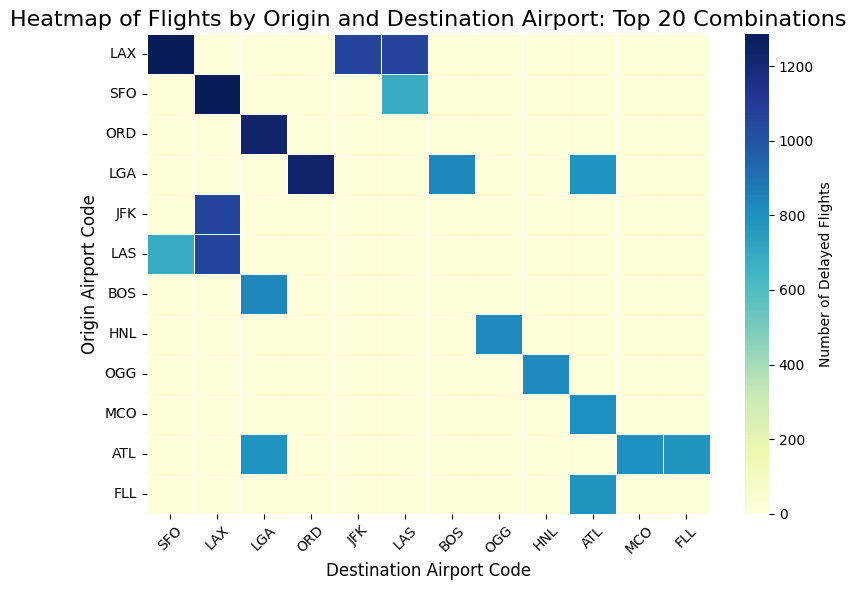

In [ ]:
# Plotting the total flights heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table_total, cmap="YlGnBu", annot=False, fmt='d', linewidths=0.5, cbar_kws={'label': 'Number of Delayed Flights'})

# Customizing the plot
plt.title('Heatmap of Flights by Origin and Destination Airport: Top 20 Combinations',
          fontsize=16)
plt.xlabel('Destination Airport Code', fontsize=12)
plt.ylabel('Origin Airport Code', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

We observe that the combinations between LAX-SFO, ORD-LGA, JFK-LAX, and LAS-LAX have the highest flight traffic between the airports. Similarly, we observe that ORD-LGA, LAX-SFO, and BOS-LGA have the highest flight traffic between the airports for delayed flights.

Using the insights from the above graphs, we determined that these features could potentially be important for our model development in predicting delayed flights. We will use further criteria in our Model Development section to refine on this feature list and pick the best features.

# Model Development


In [ ]:
# Loading in the pre-cleaned csv
df_clean = pd.read_csv('flights_df_cleaned.csv')

# dropping the origin and destination airport columns since we only needed them
# for the EDA
df_clean = df_clean[["DAY_OF_MONTH", "DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "DEP_DEL15",
            "DEP_TIME_BLK", "DISTANCE", "ORIGIN_AIRPORT_TYPE", "DEST_AIRPORT_TYPE"]].copy()

In [ ]:
# check the df
df_clean.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,DEP_DEL15,DEP_TIME_BLK,DISTANCE,ORIGIN_AIRPORT_TYPE,DEST_AIRPORT_TYPE
0,1,2,Non-budget,0.0,Early Morning,300.0,Medium Volume,High Volume
1,1,2,Non-budget,0.0,Afternoon,596.0,High Volume,High Volume
2,1,2,Non-budget,0.0,Noon,229.0,High Volume,High Volume
3,1,2,Non-budget,0.0,Afternoon,223.0,Medium Volume,High Volume
4,1,2,Non-budget,0.0,Evening,579.0,High Volume,Low Volume


In [ ]:
# Creating dummy variables for the categorical variables
df_clean_dummies = pd.get_dummies(df_clean, columns=['OP_UNIQUE_CARRIER','DEP_TIME_BLK','ORIGIN_AIRPORT_TYPE','DEST_AIRPORT_TYPE'], drop_first=True, dtype=int)
df_clean_dummies.head()

,DAY_OF_MONTH,DAY_OF_WEEK,DEP_DEL15,DISTANCE,OP_UNIQUE_CARRIER_Non-budget,DEP_TIME_BLK_Early Morning,DEP_TIME_BLK_Evening,DEP_TIME_BLK_Morning,DEP_TIME_BLK_Night,DEP_TIME_BLK_Noon,DEP_TIME_BLK_Pre Dawn,ORIGIN_AIRPORT_TYPE_Low Volume,ORIGIN_AIRPORT_TYPE_Medium Volume,DEST_AIRPORT_TYPE_Low Volume,DEST_AIRPORT_TYPE_Medium Volume
0,1,2,0.0,300.0,1,1,0,0,0,0,0,0,1,0,0
1,1,2,0.0,596.0,1,0,0,0,0,0,0,0,0,0,0
2,1,2,0.0,229.0,1,0,0,0,0,1,0,0,0,0,0
3,1,2,0.0,223.0,1,0,0,0,0,0,0,0,1,0,0
4,1,2,0.0,579.0,1,0,1,0,0,0,0,0,0,1,0


In [ ]:
# Getting a count of na's for our predicted variable
na_count = df_clean['DEP_DEL15'].isna().sum()
print(f"Number of rows with NaN in DEP_DEL15: {na_count}")

Number of rows with NaN in DEP_DEL15: 16355


In [ ]:
# Flights where DEP_DEL15 is NaN are flights that were cancelled or diverted. We will drop these rows.
df_clean_dummies.dropna(subset=['DEP_DEL15'],inplace=True)

In [ ]:
# Making the X and y then split dataset into ratio 70 and 30
X = df_clean_dummies.drop(columns=['DEP_DEL15'])
y = df_clean_dummies['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((397341, 14), (397341,), (170289, 14), (170289,))

In [ ]:
# Calculate the total number of flights
total_flights = len(y_train)

# Calculate the number of delayed flights
delayed_flights = y_train.sum()

# Calculate the number of on-time flights
on_time_flights = total_flights - delayed_flights

# Calculate the percentages
delayed_percentage = (delayed_flights / total_flights) * 100

# Print the results
print(f"Delayed Flights Percentage: {delayed_percentage:.2f}%")

Delayed Flights Percentage: 17.42%


In [ ]:
dep_delays = df_clean_dummies[df_clean_dummies['DEP_DEL15'] == 0]

# Calculate the number of rows to remove (40% of the rows where ARR_DEL15 is 0)
num_rows_to_remove = int(len(dep_delays) * 0.4)

# Randomly select rows to remove
rows_to_remove = dep_delays.sample(n=num_rows_to_remove, random_state=123)

# Remove the selected rows from the original dataframe
flight_data_dummies = df_clean_dummies.drop(rows_to_remove.index)

# Display the updated dataframe
flight_data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 380149 entries, 1 to 583984
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   DAY_OF_MONTH                       380149 non-null  int64  
 1   DAY_OF_WEEK                        380149 non-null  int64  
 2   DEP_DEL15                          380149 non-null  float64
 3   DISTANCE                           380149 non-null  float64
 4   OP_UNIQUE_CARRIER_Non-budget       380149 non-null  int64  
 5   DEP_TIME_BLK_Early Morning         380149 non-null  int64  
 6   DEP_TIME_BLK_Evening               380149 non-null  int64  
 7   DEP_TIME_BLK_Morning               380149 non-null  int64  
 8   DEP_TIME_BLK_Night                 380149 non-null  int64  
 9   DEP_TIME_BLK_Noon                  380149 non-null  int64  
 10  DEP_TIME_BLK_Pre Dawn              380149 non-null  int64  
 11  ORIGIN_AIRPORT_TYPE_Low Volume     380149 no

In [ ]:
intercept = sm.add_constant([1] * len(X_train))

intercept_only_model = sm.GLM(y_train, intercept, family=sm.families.Binomial(),link=sm.families.links.logit)
intercept_result = intercept_only_model.fit()

# Print the summary of the final model
print(intercept_result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['link']
  warnings.warn(msg, ValueWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:              DEP_DEL15   No. Observations:               397341
Model:                            GLM   Df Residuals:                   397340
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8375e+05
Date:                Tue, 10 Dec 2024   Deviance:                   3.6750e+05
Time:                        08:55:01   Pearson chi2:                 3.97e+05
No. Iterations:                     4   Pseudo R-squ. (CS):          1.110e-16
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5563      0.004   -372.062      0.0

The intercept represents the log-odds of a flight being delayed by 15 minutes or more when all predictor variables are zero (intercept-only model). A negative intercept indicates that, in the absence of any predictor effects, the log-odds of a delay are negative, suggesting a low probability of delay.

In [ ]:
# Convert log-odds to odds
log_odds_coefficient = intercept_result.params['const']
odds = np.exp(log_odds_coefficient)
print(f"Odds: {odds}")

# Convert odds to probability
probability = odds / (1 + odds)
print(f"Probability: {probability}")

Odds: 0.2109144767517818
Probability: 0.17417784723950896


This indicates that, in the absence of any predictor effects, the odds of a flight being delayed by 15 minutes or more is approximately 21.1% and the probability is approximately 17.4%

We will use the intercept-only model as our base model for comparison. Next, we will use forward stepwise selection to select the best subset of features and use the selected features to train our second model.

In [ ]:
# Define the model
model = LogisticRegression()

def calculate_bic(model, X, y):
  n_params = X.shape[1] + 1
  n = X.shape[0]
  # Calculate the log-likelihood
  y_pred_proba = model.predict_proba(X)[:, 1]
  log_likelihood = np.sum(y * np.log(y_pred_proba) + (1 - y) * np.log(1 - y_pred_proba))
  bic = -2 * log_likelihood + n_params * np.log(n)
  return bic

# Forward stepwise selection with BIC as the criterion
sfs_forward = SFS(
    model,
    k_features='best',
    forward=True,
    floating=False,
    scoring= lambda estimator, X, y : -calculate_bic(estimator, X, y),
    cv=5,
    n_jobs=-1
)

# Fit the SFS
sfs_forward = sfs_forward.fit(X_train, y_train)

# Get the selected features
selected_features = list(sfs_forward.k_feature_names_)

In [ ]:
print("Selected features:", selected_features)

Selected features: ['DAY_OF_MONTH', 'OP_UNIQUE_CARRIER_Non-budget', 'DEP_TIME_BLK_Early Morning', 'DEP_TIME_BLK_Evening', 'DEP_TIME_BLK_Morning', 'DEP_TIME_BLK_Noon', 'DEP_TIME_BLK_Pre Dawn']


The log-likelihood is calculated based on the predicted probabilities and the actual labels. This measures how well the model fits the data.

The BIC is calculated by penalizing the log-likelihood for the number of parameters and the number of observations. A lower BIC indicates a better balance between model fit and complexity.

Using the forward selection technique, ['DAY_OF_MONTH', 'OP_UNIQUE_CARRIER_Non-budget', 'DEP_TIME_BLK_Early Morning', 'DEP_TIME_BLK_Evening', 'DEP_TIME_BLK_Morning', 'DEP_TIME_BLK_Noon', 'DEP_TIME_BLK_Pre Dawn'] are the most important features for predicting flight delays. These features, when combined, resulted in the best BIC score, indicating a good balance between model fit and complexity.

In [ ]:
# Fit the final model with the selected features
X_train_selected = X_train[selected_features]
X_train_selected = sm.add_constant(X_train_selected)
final_model = sm.GLM(y_train, X_train_selected, family=sm.families.Binomial(),link=sm.families.links.logit)
final_result = final_model.fit()

# Print the summary of the final model
print(final_result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['link']
  warnings.warn(msg, ValueWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:              DEP_DEL15   No. Observations:               397341
Model:                            GLM   Df Residuals:                   397333
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7919e+05
Date:                Tue, 10 Dec 2024   Deviance:                   3.5839e+05
Time:                        08:57:24   Pearson chi2:                 3.98e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02268
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

By looking at the model output using the features selected by the forward-selection process, we can assess the following variables:

**Day of the Month**: For every one-day increase in the day of the month, the log-odds of a flight being delayed by 15 minutes or more increase by 0.0089.  So, there is a slight increase in the log-odds of delays as the day of the month increases.

**Carrier Type**: Non-budget carriers have lower log-odds of delays compared to budget carriers.

**Departure Time Blocks**: Early morning, morning, noon, and pre-dawn departures have lower log-odds of delays, while evening departures have higher log-odds of delays, as compared to the afternoon.

Next, we will produce all possible feature combinations and compare their BIC scores to select the best subset of features to use for our third model.

In [ ]:
p = len(X_train.columns)

# perform (variation) best subset selection
results = []
for k in range(0, p + 1):
    if k==0:
        # training estimation/evaluation
        X_train_subset = sm.add_constant([1] * len(y_train))
        model = sm.GLM(y_train, X_train_subset,family=sm.families.Binomial(),link=sm.families.links.logit).fit()
        aic, bic = model.aic, model.bic
        yp_train = model.predict(X_train_subset)
        rmse_train = np.sqrt(mean_squared_error(y_train, yp_train))
        # testing evaluation
        X_test_subset = sm.add_constant([1] * len(y_test))
        yp_test = model.predict(X_test_subset)
        rmse_test = np.sqrt(mean_squared_error(y_test, yp_test))
        # collect results
        results.append((k, '1', aic, bic))
    else:
        for combo in itertools.combinations(range(p), k):
            # training estimation/evaluation
            cols = X_train.columns[list(combo)]
            X_train_subset = X_train[cols]
            X_train_subset = sm.add_constant(X_train_subset)
            model = sm.GLM(y_train, X_train_subset,family=sm.families.Binomial(),link=sm.families.links.logit).fit()
            aic, bic = model.aic, model.bic
            yp_train = model.predict(X_train_subset)
            rmse_train = np.sqrt(mean_squared_error(y_train, yp_train))
            # testing evaluation
            X_test_subset = X_test[cols]
            X_test_subset = sm.add_constant(X_test_subset)
            yp_test = model.predict(X_test_subset)
            rmse_test = np.sqrt(mean_squared_error(y_test, yp_test))
            results.append((k, '+'.join(cols), aic, bic))

# convert results into dataframe
results = pd.DataFrame(results, columns=['Subset Size', 'Variables','AIC', 'BIC'])

In [ ]:
results.to_excel('results.xlsx', index=False)

In [ ]:
X_train_selected = X_train[['DAY_OF_MONTH','DISTANCE','OP_UNIQUE_CARRIER_Non-budget','DEST_AIRPORT_TYPE_Medium Volume','DEST_AIRPORT_TYPE_Low Volume','ORIGIN_AIRPORT_TYPE_Medium Volume','ORIGIN_AIRPORT_TYPE_Low Volume','DEP_TIME_BLK_Early Morning','DEP_TIME_BLK_Evening','DEP_TIME_BLK_Morning','DEP_TIME_BLK_Night','DEP_TIME_BLK_Noon','DEP_TIME_BLK_Pre Dawn']]

X_train_selected = sm.add_constant(X_train_selected)

final_model = sm.GLM(y_train, X_train_selected, family=sm.families.Binomial(),link=sm.families.links.logit)
final_result = final_model.fit()
print(final_result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['link']
  warnings.warn(msg, ValueWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:              DEP_DEL15   No. Observations:               397341
Model:                            GLM   Df Residuals:                   397327
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7909e+05
Date:                Tue, 10 Dec 2024   Deviance:                   3.5818e+05
Time:                        08:57:35   Pearson chi2:                 3.98e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02318
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Evalutaion of model output:

**Day of Month**: There is a slight increase in the log-odds of delays as the day of the month increases.

**Distance**: Longer distances slightly increase the log-odds of delays.

**Carrier Type**: Non-budget carriers have lower log-odds of delays compared to budget carriers.

**Destination Airport Type**: Low volume destination airports have lower log-odds of delays, while medium volumn destination airports have higher log-odds of delays, as compared to high volume destination airports.

**Origin Airport Type**: Medium and low volume origin airports have higher log-odds of delays, as compared to high volume origin airports.

**Departure Time Blocks**:
Early morning, morning, noon, and pre-dawn departures have lower log-odds of delays compared to afternoon departures.

Evening and night departures have higher log-odds of delays compared to afternoon departures.

Comparing the 3 models, this model has the lowest residual deviance, meaning it is closer to the saturated model and presenting the best model out of the 3.

In [ ]:
# Create an Excel file with predictions
X_test_selected = X_test[['DAY_OF_MONTH','DISTANCE','OP_UNIQUE_CARRIER_Non-budget','DEST_AIRPORT_TYPE_Medium Volume','DEST_AIRPORT_TYPE_Low Volume','ORIGIN_AIRPORT_TYPE_Medium Volume','ORIGIN_AIRPORT_TYPE_Low Volume','DEP_TIME_BLK_Early Morning','DEP_TIME_BLK_Evening','DEP_TIME_BLK_Morning','DEP_TIME_BLK_Night','DEP_TIME_BLK_Noon','DEP_TIME_BLK_Pre Dawn']]
X_test_selected = sm.add_constant(X_test_selected)
y_pred_prob = final_result.predict(X_test_selected)
y_pred = y_pred_prob.apply(lambda x: 1 if x > 0.2 else 0)

X_test_selected['DELAY'] = y_test
X_test_selected['PREDICTED_DELAY'] = y_pred
X_test_selected['PREDICTED_DELAY_PROB'] = y_pred_prob

X_test_selected.head()


,const,DAY_OF_MONTH,DISTANCE,OP_UNIQUE_CARRIER_Non-budget,DEST_AIRPORT_TYPE_Medium Volume,DEST_AIRPORT_TYPE_Low Volume,ORIGIN_AIRPORT_TYPE_Medium Volume,ORIGIN_AIRPORT_TYPE_Low Volume,DEP_TIME_BLK_Early Morning,DEP_TIME_BLK_Evening,DEP_TIME_BLK_Morning,DEP_TIME_BLK_Night,DEP_TIME_BLK_Noon,DEP_TIME_BLK_Pre Dawn,DELAY,PREDICTED_DELAY,PREDICTED_DELAY_PROB
454629,1.0,25,919.0,0,0,0,0,0,1,0,0,0,0,0,0.0,0,0.105004
243610,1.0,13,977.0,0,0,1,0,0,0,0,0,0,0,0,0.0,1,0.201989
214106,1.0,12,854.0,0,0,0,0,0,0,0,0,1,0,0,0.0,1,0.229509
476485,1.0,26,247.0,0,0,0,0,0,0,0,0,0,1,0,0.0,1,0.204826
170620,1.0,9,1250.0,1,0,0,0,0,1,0,0,0,0,0,0.0,0,0.082723


In [ ]:
X_test_selected.to_excel('predictions.xlsx', index=False)

Finally, we will take a look at the confusion matrix, the F1 score, and accuracy score.

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Confusion Matrix:
[[87912 52658]
 [13874 15845]]
F1 Score: 0.32
Accuracy: 0.61


Test data confusion matrix evaluation:

*   True postives (correctly predicted delays): 87,846
*   False positives (incorrectly predicted delays): 52,724
*   False negatives (incorrectly predicted that a flight was not delayed): 13,854
*   True negatives (correctly predicted that a flight was not delayed): 15,865

The F1 score is 0.32, indicating poor balance between precision and recall. This suggests that the model may need additional tuning.

Finally, the model has an accuracy of 61%, which means it correctly classifies about 61% of the flights.

AUC Score: 0.61


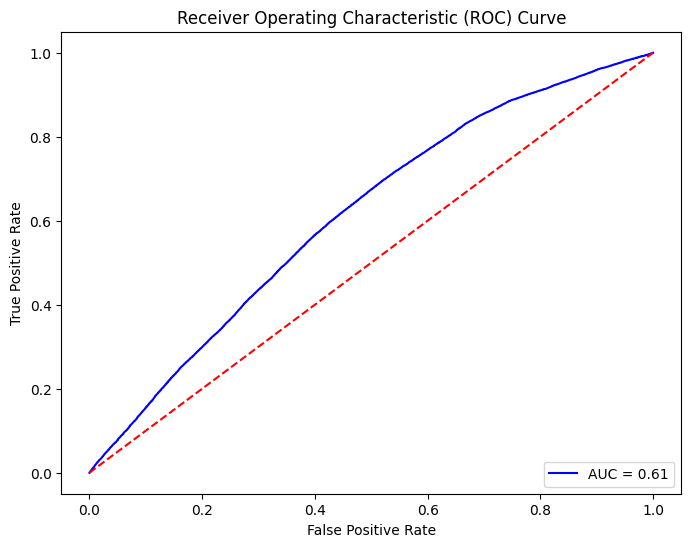

In [ ]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score:.2f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Predict on the training data
y_train_pred_prob = final_result.predict(X_train_selected)
y_train_pred = y_train_pred_prob.apply(lambda x: 1 if x > 0.2 else 0)

# Calculate the confusion matrix for training data
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix (Training Data):")
print(conf_matrix_train)

# Calculate the F1 score for training data
f1_train = f1_score(y_train, y_train_pred)
print(f"F1 Score (Training Data): {f1_train:.2f}")

# Calculate the accuracy for training data
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f"Accuracy (Training Data): {accuracy_train:.2f}")

Confusion Matrix (Training Data):
[[204865 123268]
 [ 32402  36806]]
F1 Score (Training Data): 0.32
Accuracy (Training Data): 0.61


Training data confusion matrix evaluation:

*   True postives (correctly predicted delays): 204,865
*   False positives (incorrectly predicted delays): 123,268
*   False negatives (incorrectly predicted that a flight was not delayed): 32,402
*   True negatives (correctly predicted that a flight was not delayed): 36,806

The F1 score and accuracy are the same for training and test data.

# Summary of the Project

## Data Cleaning:
The dataset was cleaned by performing the following steps:
  1. Column Selection: Retained only relevant features such as day, airline, origin/destination, departure delay, distance, and time blocks.
  2. Categorization:
    - Mapped departure time blocks into broader categories (e.g., Early Morning, Evening).
    - Grouped airlines into budget vs non-budget categories.
    - Classified airports into high, medium, and low volume based on the traffic.
  3. Handling Missing Data: Removed rows with missing target values (DEP_DEL15) caused by cancellations or diversions.
These steps ensured the data was structured and ready for modeling.

## Elementary Data Analysis:

We oberved which days of the week, days of the month, airport types, carrier types, and time blocks had higher proportion of delayed flights in order to inform our modeling process. We additionally observed that there is a significantly less diverted and cancelled flights in our dataset compared to delayed and non-delayed flights. Due to this, we can not make a meaningful multinomial regression model, so, we have chosen to only use the delayed feature as our target/dependent variable for a binomial regression model. Furthermore, we also observe a significant disproportion between delayed and non-delayed flights in our dataset, suggesting that we may need to undersample during our model construction.

## Modeling Process:
Our goal was to predict whether a flight would be delayed. We chose Binomial Regression for its simplicity and interpretability. Here is the modelling process:

1. Baseline (Intercept-only Model):

  - The baseline model included only an intercept, representing the average probability of delays without considering any features.
  - Results:
    - Odds of delay: 21.1%
    - Probability of delay: 17.4%
    - This served as a reference for evaluating our feature-based models.
  
2. Feature Selection:
  - Forward stepwise selection with BIC (Bayesian Information Criterion) was used to identify the most impactful features for predicting delays.
  - The selected features are:
    - DAY_OF_MONTH: Tracks trends in delays throughout the month.
    - OP_UNIQUE_CARRIER_Non-budget: Differentiates between budget and non-budget carriers, with non-budget carriers showing lower delay odds.
    - DEPT_TIME_BLK catergories:
      - Early Morning, Morning, Noon, and Pre Dawn: Associated with lower delay odds.
      - Evening: Shows higher delay odds.
  - This approach ensured a balance between model interpretability and performace and selecting only the most influential predictors.

3. Final Model Construction:
  - The final logistic regression model quantified how each feature impacted the odds of delays:
    - DAY_OF_MONTH: Slight increase in delay odds as the month progresses.
    - DISTANCE: Longer flights slightly increased delay odds.
    - OP_UNIQUE_CARRIER_Non-budget: Non-budget carriers were associated with lower delay odds.
    - DEP_TIME_BLK categories:
      - Early Morning, Morning, Noon, and Pre Dawn: Lower delay odds.
      - Evening and Night: Higher delay odds.
    - DEST_AIRPORT_TYPE categories:
      - Medium Volume: Minimal effect.
      - Low Volume: Associated with lower delay odds.
    - ORIGIN_AIRPORT_TYPE categories:
      - Medium Volume and Low Volume: Associated with higher delay odds.

4. Model Evaluation:

  We evaluated the final model on a test dataset using multiple metrics:
   1. Confusion Matrix:
    - True positives (Correctly Predicted Delays): 87,846
    - False Positives (Incorrectly Predicted Delays): 52,724
    - False Negatives (Missed Delays): 13,854
    - True Negatives (Correctly Predicted No Delays): 15,865
   2. Performance Metrics:
    - Accuracy: 61% - The model correctly classified 61% of flights.
    - F1 Score: 32% - The model struggled to balance precision and recall, indicating room for improvement.

## Key Takeaways and Recommendations:
1. Key Insights:
  - Departure time blocks and airline types are significant predictors of flight delays.
  - Early morning and pre-dawn flights are less likely to be delayed, while evening flights have higher delay odds.
  - Non-budget airlines and low-volume destination airports are associated with fewer delays.
2. Model Performance:
  - The baseline intercept-only model gave us a probability of 17.4% for delays.
  - Adding features through forward selection improved the model's ability to predict delays by incorporating key factors like time of the day, carrier type and distance.
  - The model acheived 61% accuracy and F1 score of 32%.
3. Next steps for improvement:
  - Gathering and addition of weather data and seasonal trends can capture external factors affecting delays.
